## Verifying the existence of TorchGAN

In [2]:
import torchgan

print(f"Existing TorchGAN {torchgan.__version__} installation found")

Existing TorchGAN v0.1.0 installation found


## Importing necessary packages

In [2]:
# General Imports
import os
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML

# Pytorch and Torchvision Imports
import torch
import torch.nn as nn
import torchvision
from torch.optim import Adam
import torch.nn as nn
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Torchgan Imports
import torchgan
from torchgan.models import *
from torchgan.losses import *
from torchgan.trainer import Trainer

Setting the manual seed helps improve reproducibility by limiting the number of sources of nondeterministic behavior in the machine or the torchgan release

Often slower to train, but may save time when debugging

In [3]:
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  999


## Loading Data

In [4]:
dataset = dsets.MNIST(
    root="./mnist",
    train=True,
    transform=transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,)),
        ]
    ),
    download=True,
)

In [5]:
dataloader = data.DataLoader(dataset, batch_size=64, shuffle=True)

## DCGAN Network

In [6]:
dcgan_network = {
    "generator": {
        "name": DCGANGenerator,
        "args": {
            "encoding_dims": 100,
            "out_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh(),
        },
        "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}},
    },
    "discriminator": {
        "name": DCGANDiscriminator,
        "args": {
            "in_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.LeakyReLU(0.2),
        },
        "optimizer": {"name": Adam, "args": {"lr": 0.0003, "betas": (0.5, 0.999)}},
    },
}

## Loss Functions

In [7]:
minimax_losses = [MinimaxGeneratorLoss(), MinimaxDiscriminatorLoss()]
wgangp_losses = [
    WassersteinGeneratorLoss(),
    WassersteinDiscriminatorLoss(),
    WassersteinGradientPenalty(),
]
lsgan_losses = [LeastSquaresGeneratorLoss(), LeastSquaresDiscriminatorLoss()]

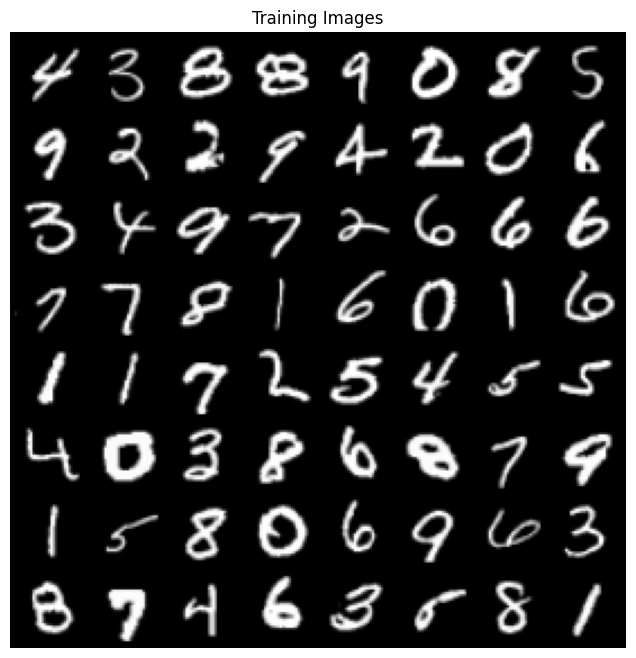

In [8]:
# Plot some of the training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(), (1, 2, 0)
    )
)
plt.show()

Recall reproducibility as discussed earlier

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # Use deterministic cudnn algorithms
    torch.backends.cudnn.deterministic = True
    epochs = 10
else:
    device = torch.device("cpu")
    epochs = 5

print("Device: {}".format(device))
print("Epochs: {}".format(epochs))

Device: cpu
Epochs: 5


In [10]:
trainer = Trainer(
    dcgan_network, lsgan_losses, sample_size=64, epochs=epochs, device=device
)

In [11]:
trainer(dataloader)


Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 424.19755697250366
generator Mean Gradients : 4.121305032550666
discriminator Mean Gradients : 17.674204299186037
Mean Running Discriminator Loss : 0.036749598787112564
Mean Running Generator Loss : 0.5800598510610524


d:\OneDrive - University of the Philippines\1 - EDUCATION\SCHOOLWORK\Undergraduate\Semester 7\CS 198\Torch-GAN Demo\tganvenv\lib\site-packages\torchvision\utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 361.09779357910156
generator Mean Gradients : 2.7783742277878454
discriminator Mean Gradients : 26.368157091659246
Mean Running Discriminator Loss : 0.0363685287034282
Mean Running Generator Loss : 0.5476353046939031
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 334.5590000152588
generator Mean Gradients : 2.792347421311369
discriminator Mean Gradients : 27.673105858792947
Mean Running Discriminator Loss : 0.03350532248546055
Mean Running Generator Loss : 0.5282927456946663
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
Epoch time duration : 321.775999546051
generator Mean Gradients : 2.8456361120264804
discriminator Mean Gradients : 27.242205599623553
Mean Running Discriminator Loss : 0.0308

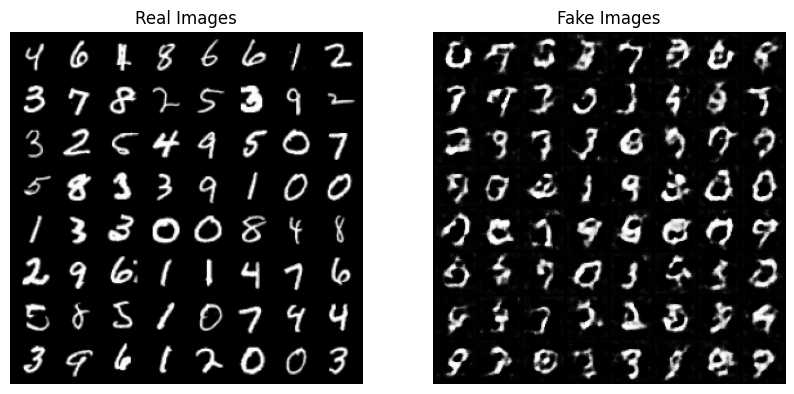

In [12]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=5, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, trainer.epochs)))
plt.show()

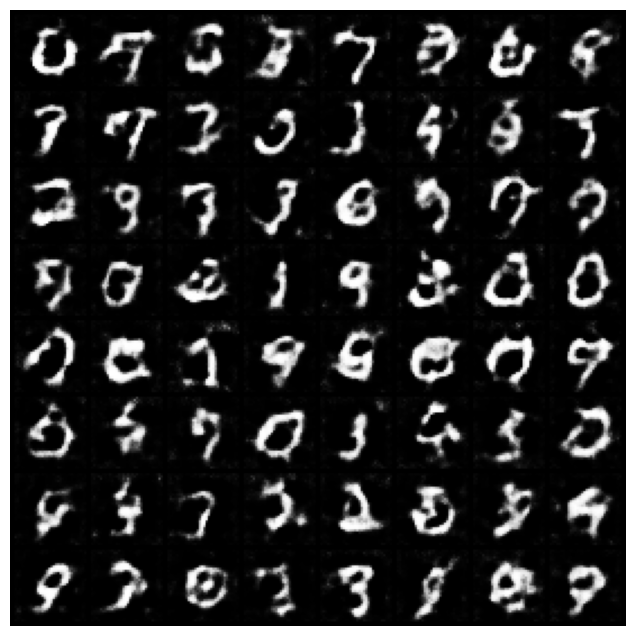

In [13]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [
    [plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, i)))]
    for i in range(1, trainer.epochs + 1)
]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# Play the animation
HTML(ani.to_jshtml())

More at https://github.com/torchgan/torchgan/blob/master/tutorials/Tutorial%201.%20Introduction%20to%20TorchGAN.ipynb